In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

In [3]:
# Datos
# ==============================================================================
df = pd.read_csv('calidadAireURDECON.csv',";",index_col=0,squeeze=True)
#df = df[["pm25","pm10","co2","humedad","temperatura","presencia"]]# Quito la última columna
#df = df[["pm25","pm10","co2","humedad","temperatura"]]
df = df[["co2","humedad"]]# Solo dejo el CO2 Y la tempeeratura (Mantengo el index de la fecha )
df = df.drop_duplicates(subset=['co2'], keep="last")  # Elimino los duplicados 
df = df.set_index(pd.to_datetime(df.index, format='%d-%m-%Y %H:%M:%S')) # Transformo el index en DateTime
#df = df.asfreq('5min')
#Los registros van de cada 5 minutos. 12 Registros = 1 hora. 48Registros = 4 horas 
df = df[:-48] #Me guardo las últimas 4 horas para la predicción
dfUltimas7Horas = df[-48:]
df.head()

,co2,humedad
fecha,,
2021-10-05 10:39:17,134.77887,41.962310
2021-10-05 10:44:17,139.66228,42.005035
2021-10-05 10:49:17,159.06667,41.980620
2021-10-05 10:54:17,121.99109,42.182040
2021-10-05 10:59:18,116.49886,42.352940


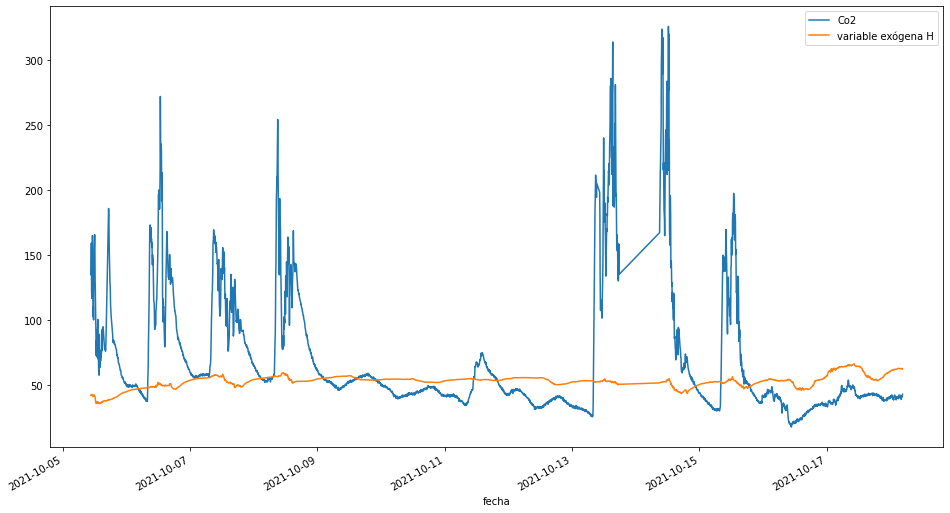

In [4]:
# Preparo datos para el modelo, solo dejo el CO2 y la variable EXÓGENA (Ej:Temperatura) # En un futuro la presencia
# ==============================================================================
#df = df['co2']
# Separo Train y Test
# ==============================================================================
steps = 48
datos_train = df[:-steps]
datos_test  = df[-steps:]

fig, ax = plt.subplots(figsize=(16, 9))
df['co2'].plot(ax=ax, label='Co2')
df['humedad'].plot(ax=ax, label='variable exógena H')
#df['temperatura'].plot(ax=ax, label='variable exógena T')
#df['pm25'].plot(ax=ax, label='variable exógena 25')
#df['pm10'].plot(ax=ax, label='variable exógena 10')
ax.legend();

In [11]:
# Separación datos train-test
# ==============================================================================
steps = 48
datos_train = df[:-steps]
datos_test  = df[-steps:]

In [12]:
datos_train.shape

(3414, 2)

# Modelo

# Tuning, HiperParametros del modelo 
A diferencia de cuando se utiliza ForecasterAutoreg o ForecasterAutoregCustom, en los modelos de tipo ForecasterAutoregMultiOutput hay que indicar, en el momento de su creación, el número de steps que se quieren predecir. Esto significa que, el número de predicciones obtenidas al ejecutar el método predict() es siempre el mismo.

In [14]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoregMultiOutput(
                    regressor = Lasso(random_state=123),
                    lags = 8,
                    steps = steps
                )


param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train['co2'],
                        exog        = datos_train['humedad'],
                        param_grid  = param_grid,
                        lags_grid = lags_grid,
                        steps       = 48,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-10-18 08:37:47,739 root       INFO  Number of models compared: 30
loop lags_grid: 100%|███████████████████████████████████████████████████████████████████| 3/3 [07:54<00:00, 158.04s/it]
2021-10-18 08:45:41,895 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
params: {'alpha': 1e-05}



In [15]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,metric,alpha
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 1e-05},1067.076697,0.000010
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0001291549665014884},1067.078529,0.000129
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0016681005372000592},1067.100785,0.001668
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.021544346900318846},1067.396560,0.021544
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.2782559402207126},1071.213579,0.278256


# Los mejores resultados se obtienen si se utiliza una ventana temporal de 20 lags y una configuración de Lasso {'alpha': 3.593813663804626}



In [18]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoregMultiOutput(
                    regressor = Lasso(random_state=123,alpha = 3.5938136638),
                    lags = 12,
                    steps = steps
                )

forecaster_rf.fit(y=datos_train['co2'], exog=datos_train['humedad'])

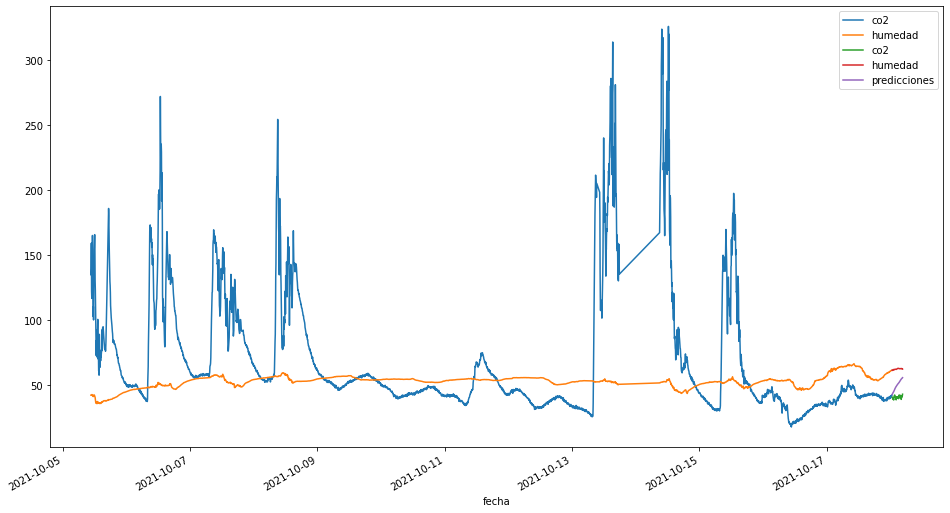

In [19]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps, exog=datos_test['humedad'])
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 9))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [20]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['co2'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 98.81887857659983
